# INFO 3402 – Class 19: Combining data exercise

[Brian C. Keegan, Ph.D.](http://brianckeegan.com/)  
[Assistant Professor, Department of Information Science](https://www.colorado.edu/cmci/people/information-science/brian-c-keegan)  
University of Colorado Boulder  

Copyright and distributed under an [MIT License](https://opensource.org/licenses/MIT)  

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib.ticker import StrMethodFormatter

import numpy as np
import pandas as pd

pd.options.display.max_columns = 200

Recall the ***crucial*** things you need to be able to answer when combining data. 

***IF YOU ARE NOT ABLE TO ANSWER THESE QUESTIONS, YOUR DATA AND ANALYSES ARE MOST LIKELY BAD!!!***

We will explore how fundamental statistics like average salary get biased because of different joining strategies.

* **Variables.** What variables do they share in common that could be used as keys in a join?
* **Coverage.** Do both tables cover the same ranges of time?
* **Duplicates.** Are there instances of multiple/repeated rows of these key variables? Why is that?
* **Strategy.** What is the most appropriate merging strategy to handle the different time windows and repeated dates?
* **Shape.** What should the data look like afterwards?  
  * How many rows? 
  * How many columns? 
  * Which values should repeat? 
  * Which values should be null? 
  * Which values should disappear?

## Exercise: A three-way join

Which schools produce the highest-paid players? We will need to combine *three* different tables to answer this question.

A *minimally* ideal DataFrame at the end might look something like:

| playerID | salary_yearID | salary | school_name |
| -------- | ------------- | ------ | ----------- |
|  |   |
|  |   |   

### Salaries

Load the salaries data. I do a bit of cleanup to make sure it's sorted by "playerID" and "yearID" to be consistent with other tabels we will look at.

In [2]:
salaries_df = pd.read_csv('./Lahman/Salaries.csv')

# I don't like the defaut sort
salaries_df = salaries_df.sort_values(['playerID','yearID']).reset_index(drop=True)

print("There are {0:,} rows.".format(len(salaries_df)))
salaries_df.head(20)

There are 26,428 rows.


,yearID,teamID,lgID,playerID,salary
0,2004,SFN,NL,aardsda01,300000
1,2007,CHA,AL,aardsda01,387500
2,2008,BOS,AL,aardsda01,403250
3,2009,SEA,AL,aardsda01,419000
4,2010,SEA,AL,aardsda01,2750000
5,2011,SEA,AL,aardsda01,4500000
6,2012,NYA,AL,aardsda01,500000
7,1986,BAL,AL,aasedo01,600000
8,1987,BAL,AL,aasedo01,625000
9,1988,BAL,AL,aasedo01,675000


* **VARIABLES**: What column/variable in this table is a good candidate to be used as a join? In other words, have you seen the values for this column in other tables?
* **COVERAGE**: What does "yearID" most likely mean in this table?  When we join this table with another table that contains a "yearID" will both mean the same thing?
* **DUPLICATES**: Which columns/variables have repeated values? Why is that?

Take the average of the "salary" column. You'll compare this average value to the average values in different kinds of joins below. 

In [6]:
salaries_df['salary'].mean()

2085634.053125473

What are reasons why this average might be a biased or unreliable metric of players' average compensation?

(Here's a hint)

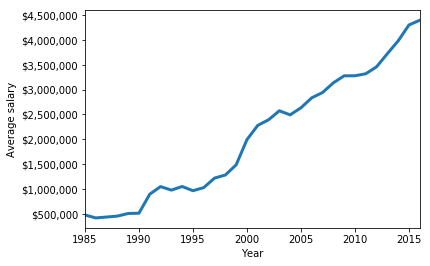

In [7]:
# Compute average salary by year
_s = salaries_df.groupby('yearID').agg({'salary':'mean'})

# Plot it out
ax = _s['salary'].plot(kind='line',lw=3)
ax.set_xlabel('Year')
ax.set_ylabel('Average salary')

# Format the y-axis
# adapted from: https://stackoverflow.com/a/46574866/1574687
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))

Rows same? True.
Players same? True.
Years same? True.
Total missing values? 0


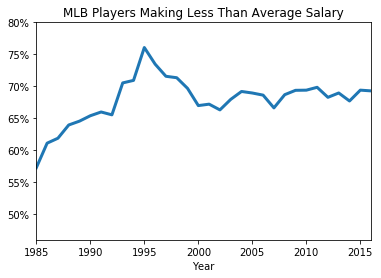

In [8]:
# Do a merge
average_salaries_df = pd.merge(left=salaries_df,right=_s,left_on='yearID',right_index=True,how='left')

# Do some checkson my merged data
print("Rows same? {0}.".format(len(salaries_df) == len(average_salaries_df)))
print("Players same? {0}.".format(len(salaries_df['playerID'].unique()) == len(average_salaries_df['playerID'].unique())))
print("Years same? {0}.".format(len(salaries_df['yearID'].unique()) == len(average_salaries_df['yearID'].unique())))
print("Total missing values? {0:,}".format(average_salaries_df.isnull().sum().sum()))

# Rename duplicated columns
average_salaries_df.rename(columns={'salary_x':'salary','salary_y':'avg_salary'},inplace=True)

# Create a new column if player salary is less than average salary
average_salaries_df['less_than'] = average_salaries_df['salary'] < average_salaries_df['avg_salary']

# Calculate the number of players with below average salaries and the total number of players per year
below_average_agg_df = average_salaries_df.groupby('yearID').agg({'less_than':'sum','playerID':len})

# Calculate the fraction of players making less than average
below_average_agg_df['fraction'] = below_average_agg_df['less_than'].div(below_average_agg_df['playerID'])

# Plot
ax = below_average_agg_df['fraction'].plot(lw=3)
ax.set_ylim((.46,.8))
ax.set_xlabel('Year')
ax.set_ylabel('')
ax.set_title("MLB Players Making Less Than Average Salary")
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.0%}'))
plt.savefig('mlb_below_average_salary_fraction.png',dpi=300)

### College playing

In [9]:
college_playing_df = pd.read_csv('./Lahman/CollegePlaying.csv')
print("There are {0:,} rows.".format(len(college_playing_df)))
college_playing_df.head(20)

There are 17,350 rows.


,playerID,schoolID,yearID
0,aardsda01,pennst,2001
1,aardsda01,rice,2002
2,aardsda01,rice,2003
3,abadan01,gamiddl,1992
4,abadan01,gamiddl,1993
5,abbeybe01,vermont,1889
6,abbeybe01,vermont,1890
7,abbeybe01,vermont,1891
8,abbeybe01,vermont,1892
9,abbotje01,kentucky,1991


* **VARIABLES**: What column/variable in this table is a good candidate to be used as a join? In other words, have you seen the values for this column in other tables?
* **COVERAGE**: What does "yearID" most likely mean in this table?  When we join this table with another table that contains a "yearID" will both mean the same thing?
* **DUPLICATES**: Which columns/variables have repeated values? Why is that?

### Schools

In [10]:
schools_df = pd.read_csv('./Lahman/Schools.csv')
print("There are {0:,} rows.".format(len(schools_df)))
schools_df.head(10)

There are 1,207 rows.


,schoolID,name_full,city,state,country
0,abilchrist,Abilene Christian University,Abilene,TX,USA
1,adelphi,Adelphi University,Garden City,NY,USA
2,adrianmi,Adrian College,Adrian,MI,USA
3,akron,University of Akron,Akron,OH,USA
4,alabama,University of Alabama,Tuscaloosa,AL,USA
5,alabamaam,Alabama A&M University,Normal,AL,USA
6,alabamast,Alabama State University,Montgomery,AL,USA
7,albanyst,Albany State University,Albany,GA,USA
8,albertsnid,Albertson College,Caldwell,ID,USA
9,albevil,Bevill State Community College,Sumiton,AL,USA


* **VARIABLES**: What column/variable in this table is a good candidate to be used as a join? In other words, have you seen the values for this column in other tables?
* **COVERAGE**: Is there temporal or other kinds of data present that may or may not overlap with other values? How could you test that?
* **DUPLICATES**: Which columns/variables have repeated values? Why is that?

## Exploring types of joins
First, we will join `college_playing_df` with `salaries_df` into `college_salaries_df`. Variables? Coverage? Duplicates? Strategy? Shape?

Let's experiment with each kind of join and come up with a ***CRYSTAL-CLEAR EXPLANATION*** for what is happening in each.

### Left join

Do a **left join** on "playerID" in `college_playing_df` and `salaries_df`.

![left join venn diagram](https://www.w3schools.com/sql/img_leftjoin.gif)

In [11]:
college_playing_df.head(3)

,playerID,schoolID,yearID
0,aardsda01,pennst,2001
1,aardsda01,rice,2002
2,aardsda01,rice,2003


In [12]:
salaries_df.head(3)

,yearID,teamID,lgID,playerID,salary
0,2004,SFN,NL,aardsda01,300000
1,2007,CHA,AL,aardsda01,387500
2,2008,BOS,AL,aardsda01,403250


In [13]:
college_salaries_left_df = pd.merge(left = college_playing_df,
                               right = salaries_df,
                               left_on = 'playerID',
                               right_on = 'playerID',
                               how = 'left')

print("There are {0:,} rows.".format(len(college_salaries_left_df)))

college_salaries_left_df.head(20)

There are 48,339 rows.


,playerID,schoolID,yearID_x,yearID_y,teamID,lgID,salary
0,aardsda01,pennst,2001,2004.0,SFN,NL,300000.0
1,aardsda01,pennst,2001,2007.0,CHA,AL,387500.0
2,aardsda01,pennst,2001,2008.0,BOS,AL,403250.0
3,aardsda01,pennst,2001,2009.0,SEA,AL,419000.0
4,aardsda01,pennst,2001,2010.0,SEA,AL,2750000.0
5,aardsda01,pennst,2001,2011.0,SEA,AL,4500000.0
6,aardsda01,pennst,2001,2012.0,NYA,AL,500000.0
7,aardsda01,rice,2002,2004.0,SFN,NL,300000.0
8,aardsda01,rice,2002,2007.0,CHA,AL,387500.0
9,aardsda01,rice,2002,2008.0,BOS,AL,403250.0


* **COVERAGE**: Why is there a "yearID_x" and a "yearID_y"? Do they mean the same thing?
* **DUPLICATES**: Which columns/variables have repeated values? Why is that?
* **SHAPE**: How many rows? How many columns? Which values should repeat? Which values should be null? Which values should disappear?

Start with a simple case of a single player, like "aardsda01". How does his values in the original table explain the values in the joined table?

In [14]:
college_playing_df.query('playerID == "aardsda01"')

,playerID,schoolID,yearID
0,aardsda01,pennst,2001
1,aardsda01,rice,2002
2,aardsda01,rice,2003


In [15]:
salaries_df.query('playerID == "aardsda01"')

,yearID,teamID,lgID,playerID,salary
0,2004,SFN,NL,aardsda01,300000
1,2007,CHA,AL,aardsda01,387500
2,2008,BOS,AL,aardsda01,403250
3,2009,SEA,AL,aardsda01,419000
4,2010,SEA,AL,aardsda01,2750000
5,2011,SEA,AL,aardsda01,4500000
6,2012,NYA,AL,aardsda01,500000


In [16]:
college_salaries_left_df.query('playerID == "aardsda01"')

,playerID,schoolID,yearID_x,yearID_y,teamID,lgID,salary
0,aardsda01,pennst,2001,2004.0,SFN,NL,300000.0
1,aardsda01,pennst,2001,2007.0,CHA,AL,387500.0
2,aardsda01,pennst,2001,2008.0,BOS,AL,403250.0
3,aardsda01,pennst,2001,2009.0,SEA,AL,419000.0
4,aardsda01,pennst,2001,2010.0,SEA,AL,2750000.0
5,aardsda01,pennst,2001,2011.0,SEA,AL,4500000.0
6,aardsda01,pennst,2001,2012.0,NYA,AL,500000.0
7,aardsda01,rice,2002,2004.0,SFN,NL,300000.0
8,aardsda01,rice,2002,2007.0,CHA,AL,387500.0
9,aardsda01,rice,2002,2008.0,BOS,AL,403250.0


Are there null values present? If so, where? Based on your join strategy, why are they there?

In [18]:
college_salaries_left_df.isnull().sum()

playerID       0
schoolID       0
yearID_x       0
yearID_y    9922
teamID      9922
lgID        9922
salary      9922
dtype: int64

In [41]:
college_salaries_left_df[college_salaries_left_df['yearID_y'].isnull()].head()

,playerID,schoolID,yearID_x,yearID_y,teamID,lgID,salary
23,abbeybe01,vermont,1889,NaN,NaN,NaN,NaN
24,abbeybe01,vermont,1890,NaN,NaN,NaN,NaN
25,abbeybe01,vermont,1891,NaN,NaN,NaN,NaN
26,abbeybe01,vermont,1892,NaN,NaN,NaN,NaN
73,abernte01,elon,1939,NaN,NaN,NaN,NaN


Are there values in the parent DataFrames that are missing in the joined DataFrames? If so, what are they? Based on your join strategy, why did they disappear?

In [24]:
len(college_playing_df['playerID'].unique())

6575

In [25]:
len(salaries_df['playerID'].unique())

5149

In [23]:
len(college_salaries_left_df['playerID'].unique())

6575

Take the average of the "salary" column in this joined table. How does it compare to the average salaries statistics above? Why is it higher or lower?

In [26]:
college_salaries_left_df['salary'].mean()

1782490.962490564

### Right join

Do a **right join** on "playerID" in `college_playing_df` and `salaries_df`.

![right join venn diagram](https://www.w3schools.com/sql/img_rightjoin.gif)

In [43]:
college_salaries_right_df = pd.merge(left = college_playing_df,
                               right = salaries_df,
                               left_on = 'playerID',
                               right_on = 'playerID',
                               how = 'right')

print("There are {0:,} rows.".format(len(college_salaries_right_df)))

college_salaries_right_df.head(20)

There are 50,896 rows.


,playerID,schoolID,yearID_x,yearID_y,teamID,lgID,salary
0,aardsda01,pennst,2001.0,2004,SFN,NL,300000
1,aardsda01,rice,2002.0,2004,SFN,NL,300000
2,aardsda01,rice,2003.0,2004,SFN,NL,300000
3,aardsda01,pennst,2001.0,2007,CHA,AL,387500
4,aardsda01,rice,2002.0,2007,CHA,AL,387500
5,aardsda01,rice,2003.0,2007,CHA,AL,387500
6,aardsda01,pennst,2001.0,2008,BOS,AL,403250
7,aardsda01,rice,2002.0,2008,BOS,AL,403250
8,aardsda01,rice,2003.0,2008,BOS,AL,403250
9,aardsda01,pennst,2001.0,2009,SEA,AL,419000


* **COVERAGE**: Why is there a "yearID_x" and a "yearID_y"? Do they mean the same thing?
* **DUPLICATES**: Which columns/variables have repeated values? Why is that?
* **SHAPE**: How many rows? How many columns? Which values should repeat? Which values should be null? Which values should disappear?

Start with a simple case of a single player, like "aardsda01". How does his values in the original table explain the values in the joined tables?

In [44]:
college_playing_df.query('playerID == "aardsda01"')

,playerID,schoolID,yearID
0,aardsda01,pennst,2001
1,aardsda01,rice,2002
2,aardsda01,rice,2003


In [45]:
salaries_df.query('playerID == "aardsda01"')

,yearID,teamID,lgID,playerID,salary
0,2004,SFN,NL,aardsda01,300000
1,2007,CHA,AL,aardsda01,387500
2,2008,BOS,AL,aardsda01,403250
3,2009,SEA,AL,aardsda01,419000
4,2010,SEA,AL,aardsda01,2750000
5,2011,SEA,AL,aardsda01,4500000
6,2012,NYA,AL,aardsda01,500000


In [46]:
college_salaries_right_df.query('playerID == "aardsda01"')

,playerID,schoolID,yearID_x,yearID_y,teamID,lgID,salary
0,aardsda01,pennst,2001.0,2004,SFN,NL,300000
1,aardsda01,rice,2002.0,2004,SFN,NL,300000
2,aardsda01,rice,2003.0,2004,SFN,NL,300000
3,aardsda01,pennst,2001.0,2007,CHA,AL,387500
4,aardsda01,rice,2002.0,2007,CHA,AL,387500
5,aardsda01,rice,2003.0,2007,CHA,AL,387500
6,aardsda01,pennst,2001.0,2008,BOS,AL,403250
7,aardsda01,rice,2002.0,2008,BOS,AL,403250
8,aardsda01,rice,2003.0,2008,BOS,AL,403250
9,aardsda01,pennst,2001.0,2009,SEA,AL,419000


Are there null values present? If so, where? Based on your join strategy, why are they there?

In [47]:
college_salaries_right_df.isnull().sum()

playerID        0
schoolID    12479
yearID_x    12479
yearID_y        0
teamID          0
lgID            0
salary          0
dtype: int64

In [49]:
college_salaries_right_df[college_salaries_right_df['yearID_x'].isnull()].head()

,playerID,schoolID,yearID_x,yearID_y,teamID,lgID,salary
38417,aasedo01,NaN,NaN,1986,BAL,AL,600000
38418,aasedo01,NaN,NaN,1987,BAL,AL,625000
38419,aasedo01,NaN,NaN,1988,BAL,AL,675000
38420,aasedo01,NaN,NaN,1989,NYN,NL,400000
38421,abadfe01,NaN,NaN,2011,HOU,NL,418000


Are there values in the parent DataFrames that are missing in the joined DataFrames? If so, what are they? Based on your join strategy, why did they disappear?

In [50]:
len(college_playing_df['playerID'].unique()), len(salaries_df['playerID'].unique()), len(college_salaries_right_df['playerID'].unique())

(6575, 5149, 5149)

Take the average of the "salary" column in this joined table. How does it compare to the average salaries statistics above? Why is it higher or lower?

In [55]:
'${:,.0f}'.format(college_salaries_right_df['salary'].mean())

'$1,934,183'

### Inner join

Do an **inner join** on "playerID" in `college_playing_df` and `salaries_df`.

![inner join venn diagram](https://www.w3schools.com/sql/img_innerjoin.gif)

In [62]:
len(college_salaries_left_df), len(college_salaries_right_df)

(48339, 50896)

In [61]:
college_salaries_inner_df = pd.merge(left = college_playing_df,
                               right = salaries_df,
                               left_on = 'playerID',
                               right_on = 'playerID',
                               how = 'inner')

print("There are {0:,} rows.".format(len(college_salaries_inner_df)))

college_salaries_inner_df.head(20)

There are 38,417 rows.


,playerID,schoolID,yearID_x,yearID_y,teamID,lgID,salary
0,aardsda01,pennst,2001,2004,SFN,NL,300000
1,aardsda01,pennst,2001,2007,CHA,AL,387500
2,aardsda01,pennst,2001,2008,BOS,AL,403250
3,aardsda01,pennst,2001,2009,SEA,AL,419000
4,aardsda01,pennst,2001,2010,SEA,AL,2750000
5,aardsda01,pennst,2001,2011,SEA,AL,4500000
6,aardsda01,pennst,2001,2012,NYA,AL,500000
7,aardsda01,rice,2002,2004,SFN,NL,300000
8,aardsda01,rice,2002,2007,CHA,AL,387500
9,aardsda01,rice,2002,2008,BOS,AL,403250


* **COVERAGE**: Why is there a "yearID_x" and a "yearID_y"? Do they mean the same thing?
* **DUPLICATES**: Which columns/variables have repeated values? Why is that?
* **SHAPE**: How many rows? How many columns? Which values should repeat? Which values should be null? Which values should disappear?

Start with a simple case of a single player, like "aardsda01". How does his values in the original table explain the values in the joined tables?

In [57]:
college_salaries_inner_df.query('playerID == "aardsda01"')

,playerID,schoolID,yearID_x,yearID_y,teamID,lgID,salary
0,aardsda01,pennst,2001.0,2004,SFN,NL,300000
1,aardsda01,rice,2002.0,2004,SFN,NL,300000
2,aardsda01,rice,2003.0,2004,SFN,NL,300000
3,aardsda01,pennst,2001.0,2007,CHA,AL,387500
4,aardsda01,rice,2002.0,2007,CHA,AL,387500
5,aardsda01,rice,2003.0,2007,CHA,AL,387500
6,aardsda01,pennst,2001.0,2008,BOS,AL,403250
7,aardsda01,rice,2002.0,2008,BOS,AL,403250
8,aardsda01,rice,2003.0,2008,BOS,AL,403250
9,aardsda01,pennst,2001.0,2009,SEA,AL,419000


Are there null values present? If so, where? Based on your join strategy, why are they there?

In [63]:
college_salaries_inner_df.isnull().sum()

playerID    0
schoolID    0
yearID_x    0
yearID_y    0
teamID      0
lgID        0
salary      0
dtype: int64

In [64]:
college_salaries_inner_df[college_salaries_inner_df['yearID_x'].isnull()].head()

,playerID,schoolID,yearID_x,yearID_y,teamID,lgID,salary


Are there values in the parent DataFrames that are missing in the joined DataFrames? If so, what are they? Based on your join strategy, why did they disappear?

In [70]:
len(college_playing_df['playerID'].unique()), len(salaries_df['playerID'].unique()), len(college_salaries_inner_df['playerID'].unique())


(6575, 5149, 2677)

In [74]:
salaries_df[~salaries_df['playerID'].isin(college_salaries_inner_df['playerID'].unique())]

,yearID,teamID,lgID,playerID,salary
7,1986,BAL,AL,aasedo01,600000
8,1987,BAL,AL,aasedo01,625000
9,1988,BAL,AL,aasedo01,675000
10,1989,NYN,NL,aasedo01,400000
12,2011,HOU,NL,abadfe01,418000
13,2012,HOU,NL,abadfe01,485000
14,2014,OAK,AL,abadfe01,525900
15,2015,OAK,AL,abadfe01,1087500
16,2016,MIN,AL,abadfe01,1250000
30,1993,OAK,AL,abbotku01,109000


Take the average of the "salary" column in this joined table. How does it compare to the average salaries statistics above? Why is it higher or lower?

In [69]:
'${:,.0f}'.format(college_salaries_inner_df['salary'].mean())

'$1,782,491'

### Outer join
Do an **outer join** on "playerID" in `college_playing_df` and `salaries_df`.

![outer join venn diagram](https://www.w3schools.com/sql/img_fulljoin.gif)

* **COVERAGE**: Why is there a "yearID_x" and a "yearID_y"? Do they mean the same thing?
* **DUPLICATES**: Which columns/variables have repeated values? Why is that?
* **SHAPE**: How many rows? How many columns? Which values should repeat? Which values should be null? Which values should disappear?

Start with a simple case of a single player, like "aardsda01". How does his values in the original table explain the values in the joined tables?

Are there null values present? If so, where? Based on your join strategy, why are they there?

Are there values in the parent DataFrames that are missing in the joined DataFrames? If so, what are they? Based on your join strategy, why did they disappear?

Take the average of the "salary" column in this joined table. How does it compare to the average salaries statistics above? Why is it higher or lower?

### Taking stock

What is the most appropriate type of join for preserving playerID, salary year, salary amount, and schoolID without unnecessary duplication?

## The second join
Join `college_salaries_df` with `schools_df` into `college_salaries_names_df`. The appropriate join strategy here is a bit more straight-forward, but you should still go through your join checklist: Variables? Coverage? Duplicates? Strategy? Shape?

## EDA
Using `college_salaries_names_df`, make a pivot table with "name_full" as an index and the mean "salary" as values. Sort the table. Which schools have the highest average salary? What is surprising here? Why might these be unusual or biased? How could you address these biases?

Using `college_salaries_names_df`, make a seaborn `catplot` or `pointplot` with "yearID" on the x-axis, "salary" on the y-axis, and hued by top programs' salaries. Note, you will probably want to filter the DataFrame down to only the top 5–10 programs.